In [1]:
import lightgbm as lgbm
import pandas as pd
import numpy as np
import re

from pymorphy2 import MorphAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer

from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy import sparse
from scipy.stats.mstats import gmean

import wordbatch
from wordbatch.extractors import WordBag

%matplotlib inline

In [2]:
train_df = pd.read_csv('../dataset/RoboMed/new_train.csv')
test_df = pd.read_csv('../dataset/RoboMed/new_test.csv')

In [3]:
train_df.head(3)

,Unnamed: 0,ID,Код_диагноза,Диагноз,Возраст,Пол,Общее состояние,аллергия,Анамнез заболевания,Внешний осмотр,Revisit,Типичные_жалобы,Типичные_услуги,Типичные_источники_рекламы
0,0,0,J06.0,Острый ларингофарингит,29,2,NaN,NaN,NaN,На жевательной поверхности 2.6- кариозная поло...,1,"на першение, осиплость | на периодическое затр...","Прием врача-оториноларинголога повторный, амбу...",Другое | Рекомендации знакомых
1,1,1,N76.1,Подострый и хронический вагинит,45,2,NaN,NaN,считает себя больной на протяжении многих лет....,NaN,1,"на выделения из половых путей ,периодические т...","Прием врача-акушера-гинеколога повторный, амбу...",Другое | Рекомендации знакомых | Интернет
2,2,2,L23.9,"Аллергический контактный дерматит, причина не ...",63,2,NaN,NaN,"Болен около 2-х дней, когда появились описанны...",NaN,1,NaN,NaN,NaN


In [4]:
def preprocess_text_feature(feature):
    return feature.str.lower() \
                  .str.replace('\n', '') \
                  .apply(lambda string: re.sub(r"([.\!?,'/()\-№:;])", ' \\1 ', string))

In [5]:
def preprocess_dataset(df):
    df['Состояние_неизвестно'] = df['Общее состояние'].isna()
    df['Аллергия_неизвестна'] = df['аллергия'].isna()
    df['Общее_состояние_неизвестно'] = df['Общее состояние'].isna()
    df['Анамнез_заболевания_неизвестен'] = df['Анамнез заболевания'].isna()
    df['Внешний_осмотр_неизвестен'] = df['Внешний осмотр'].isna()
    df['Типичные_жалобы_неизвестны'] = df['Типичные_жалобы'].isna()
    df['Типичные_услуги_неизвестны'] = df['Типичные_услуги'].isna()
    df['Типичные_источники_рекламы_неизвестны'] = df['Типичные_источники_рекламы'].isna()
    
    df['Общее состояние'].fillna('общее_состояние_неизвестно', inplace=True)
    df['аллергия'].fillna('аллергии_неизвестны', inplace=True)
    df['Анамнез заболевания'].fillna('нет_анамнеза', inplace=True)
    df['Внешний осмотр'].fillna('нет_осмотра', inplace=True)
    df['Типичные_жалобы'].fillna('типичные_жалобы_неизвестны', inplace=True)
    df['Типичные_услуги'].fillna('типичные_услги_неизвестны', inplace=True)
    df['Типичные_источники_рекламы'].fillna('типичные_источники_рекламы_неизвестны', inplace=True)
    
    df['Анамнез заболевания'] = preprocess_text_feature(df['Анамнез заболевания'])
    df['Внешний осмотр'] = preprocess_text_feature(df['Внешний осмотр'])
    df['Диагноз'] = preprocess_text_feature(df['Диагноз'])
    df['Общее состояние'] = preprocess_text_feature(df['Общее состояние'])
    df['Типичные_услуги'] = preprocess_text_feature(df['Типичные_услуги'])
    df['Типичные_жалобы'] = preprocess_text_feature(df['Типичные_жалобы'])
    df['Типичные_источники_рекламы'] = preprocess_text_feature(df['Типичные_источники_рекламы'])
    df['аллергия'] = preprocess_text_feature(df['аллергия'])
    
    df['Возраст_7'] = np.round(df['Возраст'] / 7).astype('category')
    df['Возраст_5'] = np.round(df['Возраст'] / 5).astype('category')
    df['Возраст_3'] = np.round(df['Возраст'] / 3).astype('category')
    df['Возраст_2'] = np.round(df['Возраст'] / 2).astype('category')   
    df['Возраст'] = df['Возраст'].astype('category')
    
    df['Пол'] = df['Пол'].astype('category')
    df['ID'] = df['ID'].astype('category')
    df['Код_диагноза'] = df['Код_диагноза'].astype('category')
    df['аллергия'] = df['аллергия'].astype('category')
    df['Анамнез заболевания'] = df['Анамнез заболевания'].astype('category')
    df['Внешний осмотр'] = df['Внешний осмотр'].astype('category')
    return df

In [6]:
train_df = preprocess_dataset(train_df)
test_df = preprocess_dataset(test_df)

In [7]:
y_train = train_df.Revisit
train_df = train_df.drop('Revisit', axis='columns')

In [8]:
whole_df = pd.concat([train_df, test_df])

In [9]:
def label_with_pos(text):
    analyzer = MorphAnalyzer()
    tokens = re.compile('[\W+]').sub(' ', text).lower().strip().split()
    tokens = [x for x in tokens if len(x) > 1]
    result = []
    for token in tokens:
        parsed_result = analyzer.parse(token)
        pos = parsed_result[0].tag.POS
        pos_token = token + ('' if pos is None else '_' + pos)
        result.append(pos_token)
    return ' '.join(result)

In [10]:
def one_hot_texts(text_feature):
    wb = wordbatch.WordBatch(extractor=(WordBag, {"hash_ngrams": 2, "hash_ngrams_weights": [1.0, 1.0],
                                                  "hash_size": 2 ** 22, "norm": None,
                                                  "tf": 5.0, "idf": 5.0,}), procs=32)
    wb.dictionary_freeze = True
    transformed_feature = wb.fit_transform(text_feature)
    nnz_features_mask = np.clip(transformed_feature.getnnz(axis=0) - 1, 0, 1).astype(bool)
    transformed_feature = transformed_feature[:, nnz_features_mask]
    return transformed_feature

In [11]:
text_feature_names = ['Общее состояние', 'аллергия', 'Анамнез заболевания', 'Внешний осмотр',
                      'Диагноз', 'Типичные_жалобы', 'Типичные_услуги', 'Типичные_источники_рекламы']
transformed_matrices = [one_hot_texts(whole_df[feature_name])
                        for feature_name in tqdm(text_feature_names)]
text_features_matrix = sparse.hstack(transformed_matrices)

  0%|          | 0/8 [00:00<?, ?it/s]

Normalize text
Extract wordbags


 12%|█▎        | 1/8 [00:12<01:27, 12.55s/it]

Normalize text
Extract wordbags


 25%|██▌       | 2/8 [00:25<01:15, 12.59s/it]

Normalize text
Extract wordbags


 38%|███▊      | 3/8 [00:38<01:03, 12.75s/it]

Normalize text
Extract wordbags


 50%|█████     | 4/8 [00:50<00:50, 12.70s/it]

Normalize text
Extract wordbags


 62%|██████▎   | 5/8 [01:03<00:38, 12.75s/it]

Normalize text
Extract wordbags


 75%|███████▌  | 6/8 [01:19<00:26, 13.32s/it]

Normalize text
Extract wordbags


 88%|████████▊ | 7/8 [01:33<00:13, 13.32s/it]

Normalize text
Extract wordbags


100%|██████████| 8/8 [01:46<00:00, 13.33s/it]


In [12]:
patient_dummies = sparse.csr_matrix(
    pd.get_dummies(whole_df[['Возраст', 'Код_диагноза', 'Пол']], sparse=True).values)

age_dummies = sparse.csr_matrix(
    pd.get_dummies(whole_df[['Возраст_2', 'Возраст_3', 'Возраст_5', 'Возраст_7']], sparse=True).values)

In [13]:
nan_feature_names = ['Состояние_неизвестно', 'Аллергия_неизвестна', 'Общее_состояние_неизвестно',
                     'Анамнез_заболевания_неизвестен', 'Внешний_осмотр_неизвестен',
                     'Типичные_жалобы_неизвестны', 'Типичные_услуги_неизвестны',
                     'Типичные_источники_рекламы_неизвестны']
nan_dummies = sparse.csr_matrix(pd.get_dummies(whole_df[nan_feature_names], sparse=True).values)

In [14]:
vectorizer = CountVectorizer()
diagnosis_counts = vectorizer.fit_transform(whole_df['Код_диагноза'].apply(str))

vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 2))
diagnosis_counts_char = vectorizer.fit_transform(whole_df['Код_диагноза'].apply(str))

In [15]:
def remove_unsued_features(mat):
    nnz_mask = np.clip(mat.getnnz(axis=0) - 1, 0, 1).astype(bool)
    mat = mat[:, nnz_mask]
    return mat

In [ ]:
patient_dummies = remove_unsued_features(patient_dummies)
nan_dummies = remove_unsued_features(nan_dummies)
age_dummies = remove_unsued_features(age_dummies)

In [46]:
whole_features_matrix = sparse.hstack([
    text_features_matrix, patient_dummies, age_dummies,
    nan_dummies, diagnosis_counts, diagnosis_counts_char,
    sparse.csr_matrix(whole_df.Возраст).T,
    sparse.csr_matrix(whole_df.Пол.astype('category').cat.codes).T,
    sparse.csr_matrix(whole_df.Диагноз.astype('category').cat.codes).T
]).tocsr()

In [47]:
features_train = whole_features_matrix[:len(train_df)]
features_test = whole_features_matrix[len(train_df):]

In [49]:
predictions = []

for random_state in tqdm(range(0, 100, 10)):
    params = {
        'application': 'binary',
        'verbosity': -1,
        'metric': 'auc',
        'feature_fraction_seed' : random_state + 10,
        'bagging_seed' : random_state + 20
    }
    stratified = KFold(n_splits=10, shuffle=True, random_state=random_state)
    for train_index, test_index in stratified.split(features_train, y_train):
        x_t, x_v = features_train[train_index], features_train[test_index]
        y_t, y_v = y_train[train_index], y_train[test_index]

        dataset_train = lgbm.Dataset(x_t, label=y_t)
        dataset_valid = lgbm.Dataset(x_v, label=y_v)
        watchlist = [dataset_train, dataset_valid]
        
        model = lgbm.train(params, train_set=dataset_train, valid_sets=watchlist,
                          num_boost_round=400, early_stopping_rounds=200, verbose_eval=1000)
        preds = model.predict(x_v)
#         print("roc_auc_score: ", roc_auc_score(y_v, preds))
        predictions.append(model.predict(features_test))
        
preds = gmean(np.array(predictions), axis=0)


  0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 200 rounds.



Exception in thread Thread-56:
Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/root/miniconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/root/miniconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



Early stopping, best iteration is:
[162]	training's auc: 0.743659	valid_1's auc: 0.7233
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[115]	training's auc: 0.738321	valid_1's auc: 0.718954
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[147]	training's auc: 0.74172	valid_1's auc: 0.722478
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[192]	training's auc: 0.745824	valid_1's auc: 0.725325
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's auc: 0.761671	valid_1's auc: 0.720972
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[150]	training's auc: 0.741815	valid_1's auc: 0.721358
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[168]	training's auc: 0.742928	valid_

 10%|█         | 1/10 [02:37<23:33, 157.06s/it]

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[84]	training's auc: 0.733475	valid_1's auc: 0.725883
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[165]	training's auc: 0.742679	valid_1's auc: 0.727408
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[149]	training's auc: 0.742366	valid_1's auc: 0.71498
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's auc: 0.762227	valid_1's auc: 0.715756
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[195]	training's auc: 0.745912	valid_1's auc: 0.727227
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[100]	training's auc: 0.735866	valid_1's auc: 0.723741
Training until validation scores don't improve for 200 rounds.
Early st

 20%|██        | 2/10 [05:08<20:35, 154.45s/it]

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[176]	training's auc: 0.744422	valid_1's auc: 0.725389
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[137]	training's auc: 0.740626	valid_1's auc: 0.722122
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[109]	training's auc: 0.736736	valid_1's auc: 0.722186
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's auc: 0.761388	valid_1's auc: 0.720571
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[124]	training's auc: 0.738509	valid_1's auc: 0.722789
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[154]	training's auc: 0.742544	valid_1's auc: 0.72128
Training until validation scores don't improve for 200 rounds.
Early s

 30%|███       | 3/10 [07:39<17:51, 153.11s/it]

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[167]	training's auc: 0.743966	valid_1's auc: 0.724016
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[190]	training's auc: 0.745518	valid_1's auc: 0.725545
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[173]	training's auc: 0.744359	valid_1's auc: 0.721767
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[186]	training's auc: 0.745748	valid_1's auc: 0.722578
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[156]	training's auc: 0.742651	valid_1's auc: 0.723012
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[121]	training's auc: 0.737705	valid_1's auc: 0.730979
Training until validation scores don't improve for 200 rounds.
Did not meet early 

 40%|████      | 4/10 [10:15<15:22, 153.79s/it]

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[103]	training's auc: 0.736384	valid_1's auc: 0.720628
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[151]	training's auc: 0.741721	valid_1's auc: 0.724871
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[199]	training's auc: 0.746403	valid_1's auc: 0.726844
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[167]	training's auc: 0.74321	valid_1's auc: 0.727405
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[173]	training's auc: 0.744888	valid_1's auc: 0.717292
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[154]	training's auc: 0.742135	valid_1's auc: 0.724797
Training until validation scores don't improve for 200 rounds.
Early stopping, best

 50%|█████     | 5/10 [12:55<12:55, 155.14s/it]

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[147]	training's auc: 0.741453	valid_1's auc: 0.721118
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[161]	training's auc: 0.742898	valid_1's auc: 0.722733
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[145]	training's auc: 0.741387	valid_1's auc: 0.723819
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[170]	training's auc: 0.743783	valid_1's auc: 0.724885
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[168]	training's auc: 0.743019	valid_1's auc: 0.72918
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[159]	training's auc: 0.743255	valid_1's auc: 0.720375
Training until validation scores don't improve for 200 rounds.
Early stopping, best

 60%|██████    | 6/10 [15:29<10:19, 154.94s/it]

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's auc: 0.76222	valid_1's auc: 0.720062
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[142]	training's auc: 0.740462	valid_1's auc: 0.727546
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[168]	training's auc: 0.743477	valid_1's auc: 0.723327
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[119]	training's auc: 0.738074	valid_1's auc: 0.723307
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[96]	training's auc: 0.735327	valid_1's auc: 0.721204
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[141]	training's auc: 0.740672	valid_1's auc: 0.725735
Training until validation scores don't improve for 200 rounds.
Early st

 70%|███████   | 7/10 [17:58<07:42, 154.05s/it]

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[176]	training's auc: 0.745278	valid_1's auc: 0.714819
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[150]	training's auc: 0.741432	valid_1's auc: 0.726041
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's auc: 0.761699	valid_1's auc: 0.72491
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[142]	training's auc: 0.740529	valid_1's auc: 0.726737
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[149]	training's auc: 0.741411	valid_1's auc: 0.725027
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's auc: 0.760836	valid_1's auc: 0.728283
Training until validation scores don't improve for 200 ro

 80%|████████  | 8/10 [21:33<05:23, 161.69s/it]

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[172]	training's auc: 0.7437	valid_1's auc: 0.724808
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[150]	training's auc: 0.741965	valid_1's auc: 0.722684
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[113]	training's auc: 0.737911	valid_1's auc: 0.719409
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's auc: 0.761483	valid_1's auc: 0.723084
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[166]	training's auc: 0.743391	valid_1's auc: 0.726133
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's auc: 0.761975	valid_1's auc: 0.719901
Training until validation scores don't improve for 200 rou

 90%|█████████ | 9/10 [25:14<02:48, 168.30s/it]

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[127]	training's auc: 0.739213	valid_1's auc: 0.721857
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's auc: 0.761981	valid_1's auc: 0.721772
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[121]	training's auc: 0.7387	valid_1's auc: 0.724256
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[120]	training's auc: 0.738439	valid_1's auc: 0.723397
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's auc: 0.761904	valid_1's auc: 0.722686
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[145]	training's auc: 0.741435	valid_1's auc: 0.724107
Training until validation scores don't improve for 200 rou

100%|██████████| 10/10 [27:49<00:00, 166.99s/it]


In [53]:
submission = pd.read_csv('/root/dataset/RoboMed/sample_submission.csv')
submission.proba = preds
submission.to_csv('submission_boosting.csv', index=False)

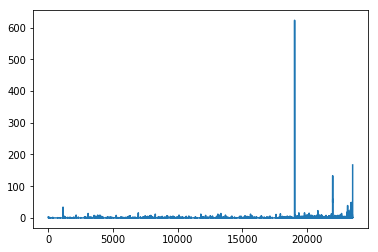

In [50]:
plt.plot(model.feature_importance())

In [52]:
model.feature_importance()

array([  3,   0,   0, ...,   0,   0, 167])